## Решающие деревья

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

Реализуем функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуем дисперсию подвыборки, а для задачи классификации – критерий Джини

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы.

In [6]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    def find_H(s, l):
        first = (l/(s + 1))**2
        second = (1 - l/(s + 1))**2
        return (1 - first - second)
    
    def find_Q_classification(R_l, R_r):
        first = len(R_l) * find_H(sum(R_l), len(R_r))/len(feature_vector)
        second = len(R_r) * find_H(sum(R_r), len(R_r))/len(feature_vector)
        return (-(first + second))
    
    def find_Q_regression(R_l, R_r):
        first = len(R_l) * (np.var(R_l))/len(feature_vector)
        second = len(R_r) * (np.var(R_r))/len(feature_vector)
        return (-(first + second))
    
    def find_Rl_and_Rr_1(t):
        R_l = target_vector[feature_vector == t]
        R_r = target_vector[~(feature_vector == t)]
        return R_l, R_r
    
    def find_Rl_and_Rr_2(t):
        R_l = target_vector[feature_vector > t]
        R_r = target_vector[~(feature_vector > t)]
        return R_l, R_r
        
    thresholds = np.array(sorted(np.unique(feature_vector))) 
    ginis = []
    
    if task == 'regression':
        if feature_type == 'real':
            thresholds = (thresholds[1:] + thresholds[:-1])/2
            
        if feature_type == 'categorical':
            for t in thresholds:
                R_l, R_r = find_Rl_and_Rr_1(t)
                ginis.append(find_Q_regression(R_l, R_r))
        else:    
            for t in thresholds:
                R_l, R_r = find_Rl_and_Rr_2(t)
                ginis.append(find_Q_regression(R_l, R_r))
          
    if task == 'classification':
        if feature_type == 'real':
            thresholds = (thresholds[1:] + thresholds[:-1])/2
            
        if feature_type == 'categorical':
            for t in thresholds:
                R_l, R_r = find_Rl_and_Rr_1(t)
                ginis.append(find_Q_classification(R_l, R_r))
        else:    
            for t in thresholds:
                R_l, R_r = find_Rl_and_Rr_2(t)
                ginis.append(find_Q_classification(R_l, R_r))
                
    ginis = np.array(ginis)  
    threshold_best = thresholds[ginis.argmax()]
    gini_best = ginis[ginis.argmax()]     

    return thresholds, ginis, threshold_best, gini_best

Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
type(y)

numpy.ndarray

Выведем график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

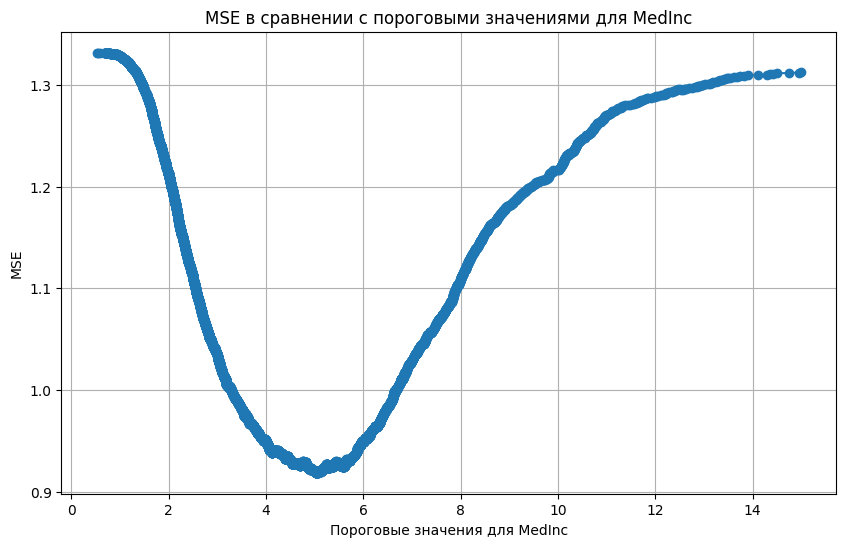

In [10]:
feature_vector = X['MedInc'].to_numpy()

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

thresholds = (np.unique(feature_vector)[:-1] + np.unique(feature_vector)[1:]) / 2

mse_values = []
for t in thresholds:
    left_mask = feature_vector <= t
    right_mask = feature_vector > t
    left_mean = np.mean(y[left_mask])
    right_mean = np.mean(y[right_mask])
    y_pred = np.where(left_mask, left_mean, right_mean)
    mse_values.append(mse(y, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, mse_values, marker='o')
plt.xlabel('Пороговые значения для MedInc')
plt.ylabel('MSE')
plt.title('MSE в сравнении с пороговыми значениями для MedInc')
plt.grid(True)
plt.show()

Найдем лучший предикат первой вершины решающего дерева.

In [11]:
def find_best_split(feature_vector, target_vector):
    thresholds = (np.unique(feature_vector)[:-1] + np.unique(feature_vector)[1:]) / 2
    best_threshold = None
    best_mse = float('inf')
    
    for t in thresholds:
        left_mask = feature_vector <= t
        right_mask = feature_vector > t
        left_mean = np.mean(target_vector[left_mask])
        right_mean = np.mean(target_vector[right_mask])
        y_pred = np.where(left_mask, left_mean, right_mean)
        current_mse = mse(target_vector, y_pred)
        
        if current_mse < best_mse:
            best_mse = current_mse
            best_threshold = t
            
    return best_threshold, best_mse

best_splits = {}
for feature in X.columns[1:]:
    feature_vector = X[feature].to_numpy()
    best_threshold, best_mse = find_best_split(feature_vector, y)
    best_splits[feature] = (best_threshold, best_mse)

best_feature = min(best_splits, key=lambda k: best_splits[k][1])
best_threshold, best_mse = best_splits[best_feature]

best_feature, best_threshold, best_mse


('AveRooms', 6.374305146225346, 1.1723423474925827)

# Реализуем решающее дерево

Построение дерева осуществляется согласно базовому жадному алгоритму
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [12]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._feature_importances = {}
        
    def _fit_node(self, sub_X: np.ndarray, sub_y: np.ndarray, node: dict) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        
        feature_split = node["feature_split"]
        
        if self._feature_types[feature_split] == "real":
            if x[feature_split] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_split] == "categorical":
            if x[feature_split] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

Загрузим таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Построим на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируем диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [13]:
df = pd.read_csv('students1.csv')
df.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


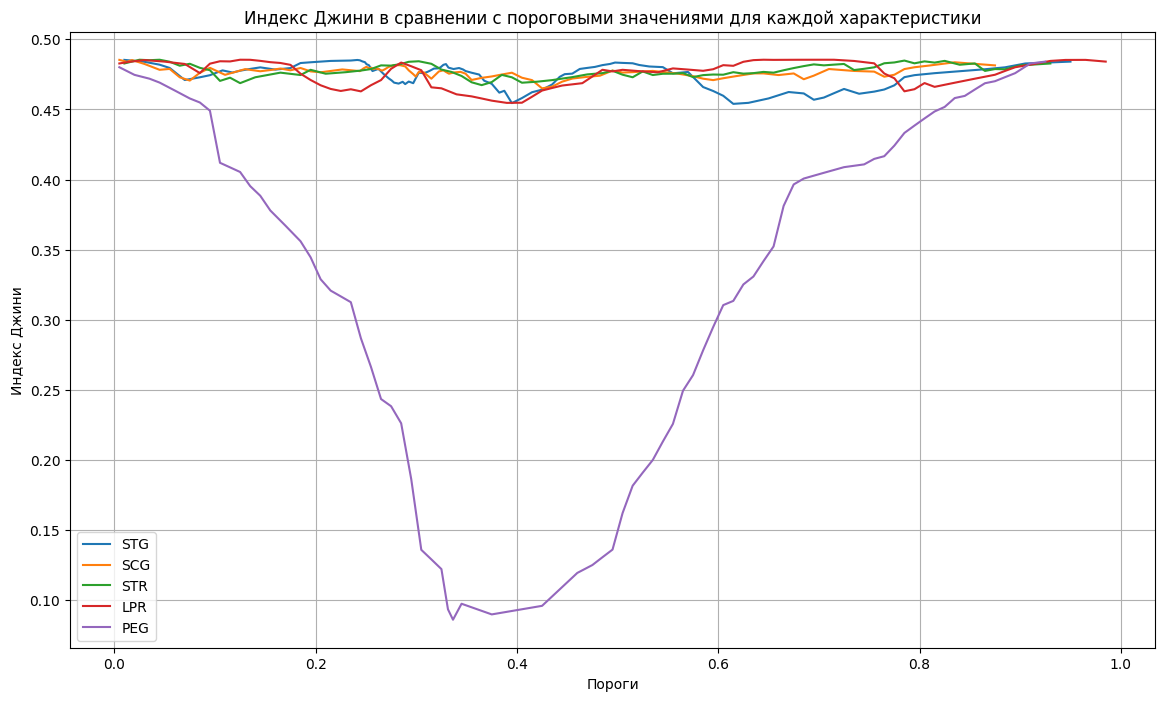

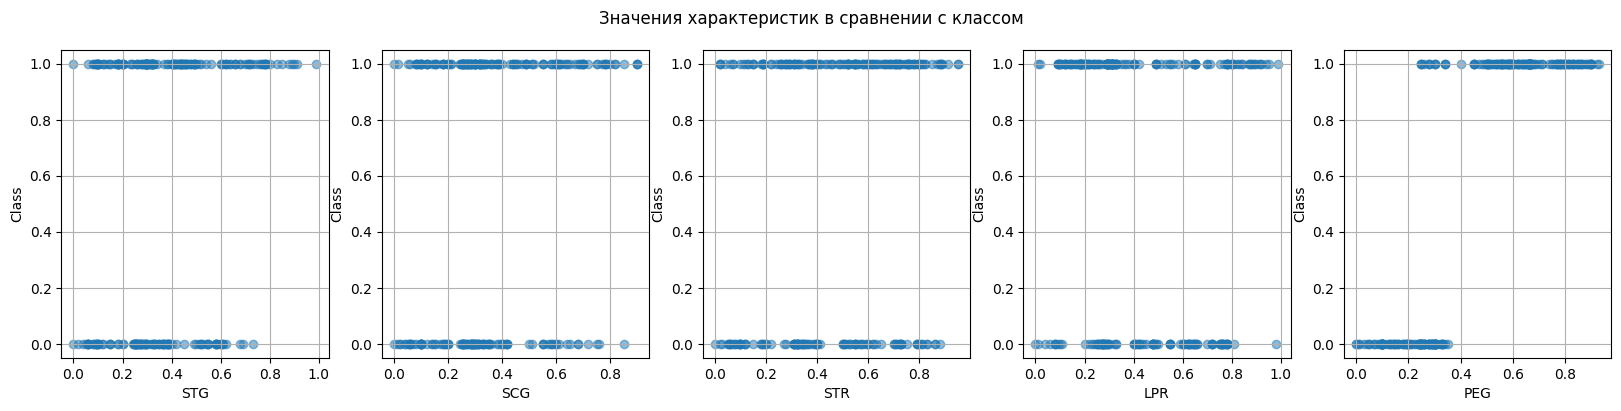

In [14]:
features = df.columns[1:-1]
X = df[features].to_numpy()
y = df['UNS'].to_numpy()

def gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = (group == class_val).sum() / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def evaluate_splits_for_feature(feature_vector, target_vector):
    thresholds = (np.unique(feature_vector)[:-1] + np.unique(feature_vector)[1:]) / 2
    gini_values = []
    
    for t in thresholds:
        left_mask = feature_vector <= t
        right_mask = feature_vector > t
        left_group = target_vector[left_mask]
        right_group = target_vector[right_mask]
        gini = gini_index([left_group, right_group], np.unique(target_vector))
        gini_values.append(gini)
    
    return thresholds, gini_values

plt.figure(figsize=(14, 8))
for feature in features:
    feature_vector = df[feature].to_numpy()
    thresholds, gini_values = evaluate_splits_for_feature(feature_vector, y)
    plt.plot(thresholds, gini_values, label=feature)

plt.xlabel('Пороги')
plt.ylabel('Индекс Джини')
plt.title('Индекс Джини в сравнении с пороговыми значениями для каждой характеристики')
plt.legend()
plt.grid(True)
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, feature in enumerate(features):
    axs[i].scatter(df[feature], y, alpha=0.5)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Class')
    axs[i].grid(True)

plt.suptitle('Значения характеристик в сравнении с классом')
plt.show()


Исходя из кривых значений критерия Джини, следует выбирать признак, у которого значение Джини минимально на каком-то пороге, поскольку это указывает на лучшее разделение.
На графиках видно, что признак LPR имеет наиболее низкое значение критерия Джини, что указывает на его лучшую способность разделять классы.

Диаграммы рассеяния также показывают, что признак LPR хорошо разделяет классы 0 и 1. Для этого признака видно, что существует пороговое значение, разделяющее классы, что подтверждает результат анализа кривых Джини.
Признаки STG и SCG также показывают некоторое разделение классов, но не так четко, как LPR.

Для "хороших" признаков кривая критерия Джини имеет заметное глубокое падение (минимум), что указывает на точку, где выборка делится почти идеально.
Кривая резко снижается до минимального значения и затем резко увеличивается, что указывает на наличие хорошего порога для разделения.

Для признаков, по которым деление невозможно, кривая критерия Джини будет относительно плоской, без глубоких минимумов.
Это указывает на то, что для любого порога разделение классов не улучшает метрику качества (например, признаки STR и PEG имеют такие плоские кривые).

Протестируем свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 


Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучим решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделаем предсказания для оставшейся половины. Посчитаем accuracy

In [16]:
mushroom_df = pd.read_csv('agaricus-lepiota.data', header=None)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

label_encoders = {}
for column in mushroom_df.columns:
    le = LabelEncoder()
    mushroom_df[column] = le.fit_transform(mushroom_df[column])
    label_encoders[column] = le

X = mushroom_df.iloc[:, 1:].values
y = mushroom_df.iloc[:, 0].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy


1.0

accuracy равно 1 

^_^

## Бэггинг и случайный лес

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [17]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [18]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

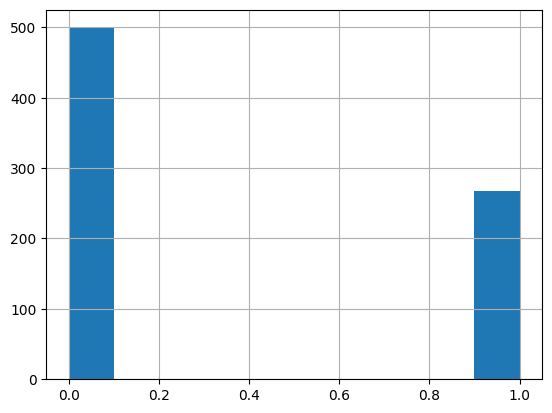

In [19]:
data['Outcome'].hist()
plt.show()

Разделим данные на признаки и целевую переменную. Разобьем датасет на обучающую и тестовую части в отношении 7:3. Затем разделим обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [20]:
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)


(((375, 8), (375,)), ((162, 8), (162,)), ((231, 8), (231,)))

На обучающей-валидационной выборке подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создадим списки с возможными значениями для перебора.
2. Для каждой пары значений обучим дерево на обучающей-обучающей выборке и определим качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберим ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучим решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оценим качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [21]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

max_depth_values = [3, 4, 5, 6, 7, 8, 9, 10, None]
min_samples_leaf_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_val_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_params = {"max_depth": max_depth, "min_samples_leaf": min_samples_leaf}

best_params, best_f1

({'max_depth': 7, 'min_samples_leaf': 7}, 0.7142857142857143)

In [22]:
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.hstack((y_train, y_val))

clf = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=42)
clf.fit(X_train_full, y_train_full)

y_test_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

accuracy, precision, recall, roc_auc

(0.696969696969697, 0.5555555555555556, 0.625, 0.6800496688741722)

Обучим [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оценим качество классификации на тестовой выборке по тем же метрикам.

In [23]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf']), n_estimators=50, random_state=42)
bagging_clf.fit(X_train_full, y_train_full)

y_test_pred_bagging = bagging_clf.predict(X_test)

accuracy_bagging = accuracy_score(y_test, y_test_pred_bagging)
precision_bagging = precision_score(y_test, y_test_pred_bagging)
recall_bagging = recall_score(y_test, y_test_pred_bagging)
roc_auc_bagging = roc_auc_score(y_test, y_test_pred_bagging)

accuracy_bagging, precision_bagging, recall_bagging, roc_auc_bagging


(0.7705627705627706, 0.6626506024096386, 0.6875, 0.7510347682119205)

Выполним кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создадим списки с возможными значениями для перебора.
2. Для каждой пары значений проведем кросс-валидацию на полной обучающей выборке. В качестве критерия будем использовать `f1-меру`. Усредним значение критерия по всем прогонам кросс-валидации. 
3. Выберем ту пару значений, которая даёт наилучшее среднее качество. 

Обучим случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оценим качество классификации по тем же метрикам.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
min_samples_split_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]

best_f1 = 0
best_params_rf = {}

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rf_clf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        f1_scores = cross_val_score(rf_clf, X_train_full, y_train_full, cv=5, scoring='f1')
        mean_f1 = f1_scores.mean()
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params_rf = {"max_depth": max_depth, "min_samples_split": min_samples_split}

best_params_rf, best_f1


({'max_depth': 7, 'min_samples_split': 6}, 0.6835776772247361)

In [25]:
best_rf_clf = RandomForestClassifier(n_estimators=50, max_depth=best_params_rf['max_depth'], min_samples_split=best_params_rf['min_samples_split'], random_state=42)
best_rf_clf.fit(X_train_full, y_train_full)

y_test_pred_rf = best_rf_clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
precision_rf = precision_score(y_test, y_test_pred_rf)
recall_rf = recall_score(y_test, y_test_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_test_pred_rf)

accuracy_rf, precision_rf, recall_rf, roc_auc_rf

(0.7575757575757576, 0.6463414634146342, 0.6625, 0.7352235099337749)

Давайте вспомним. Accuracy, precision, recall, roc_auc

Decision Tree: (0.696969696969697, 0.5555555555555556, 0.625, 0.6800496688741722)

BaggingClassifier: (0.7705627705627706, 0.6626506024096386, 0.6875, 0.7510347682119205)

RandomForestClassifier: (0.7575757575757576, 0.6463414634146342, 0.6625, 0.7352235099337749)

Лучше всего оказался BaggingClassifier по всем метрикам

Построим график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке

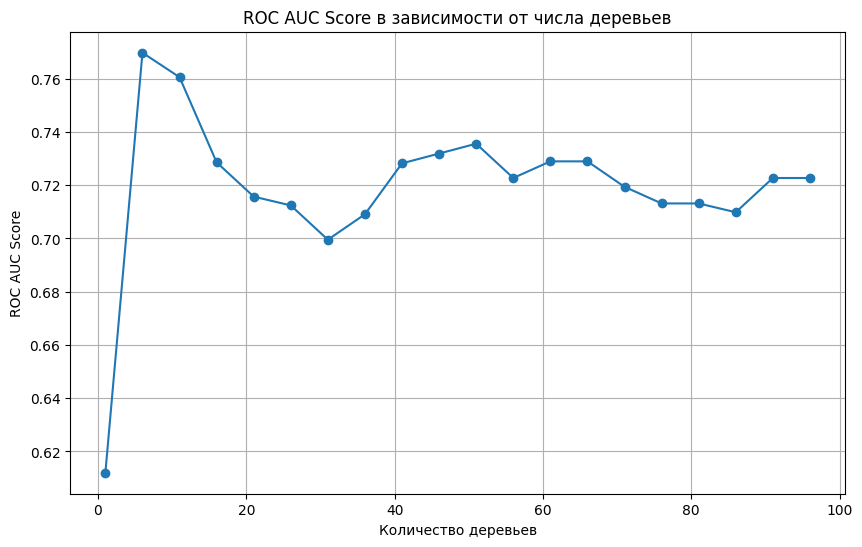

In [26]:
n_estimators_range = range(1, 101, 5)
roc_auc_scores = []

for n_estimators in n_estimators_range:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_params_rf['max_depth'], min_samples_split=best_params_rf['min_samples_split'], random_state=42)
    rf_clf.fit(X_train_full, y_train_full)
    y_test_pred_rf = rf_clf.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_test_pred_rf)
    roc_auc_scores.append(roc_auc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, roc_auc_scores, marker='o')
plt.xlabel('Количество деревьев')
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Score в зависимости от числа деревьев')
plt.grid(True)
plt.show()


Вначале увеличение числа деревьев приводит к росту ROC AUC, что указывает на улучшение качества модели. На графике видно, что после добавления первых 20 деревьев значение ROC AUC существенно увеличивается.

После определенного количества деревьев (около 30-40 деревьев) качество модели выходит на плато, и дальнейшее увеличение числа деревьев не приводит к значительному улучшению ROC AUC.
Небольшие колебания значений ROC AUC после достижения плато могут быть связаны с случайными вариациями в процессе обучения, но они несущественны.
Оптимальное количество деревьев:

Оптимальное количество деревьев для данной задачи, по-видимому, находится в диапазоне от 20 до 40 деревьев, после чего прирост качества становится минимальным.
Таким образом, для достижения хорошего баланса между качеством модели и затратами на вычисления имеет смысл использовать случайный лес с количеством деревьев в диапазоне 20-40

Для лучшей модели случайного леса посчитаем важность признаков и построем bar plot.

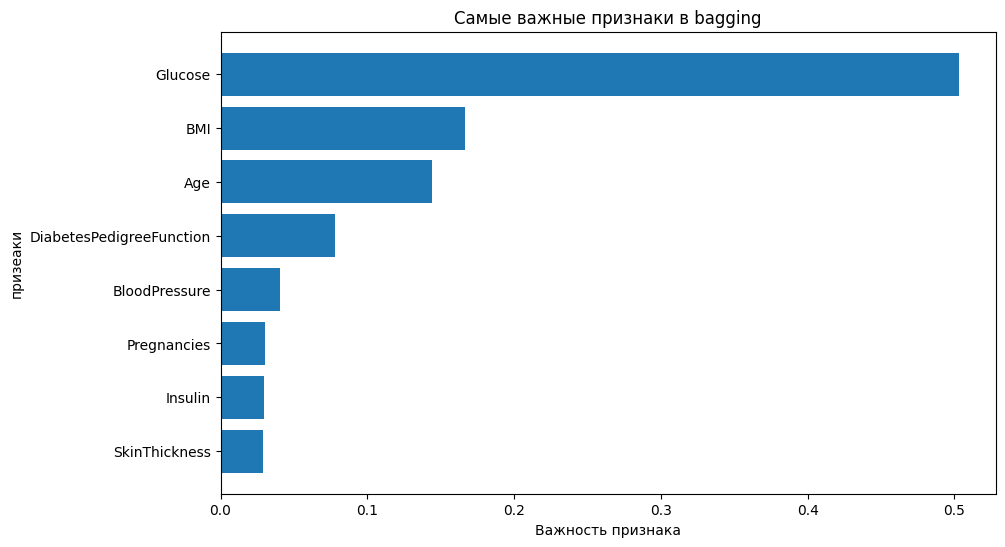

,Feature,Importance
1,Glucose,0.502905
5,BMI,0.166354
7,Age,0.143932
6,DiabetesPedigreeFunction,0.077907
2,BloodPressure,0.040299
0,Pregnancies,0.030135
4,Insulin,0.029381
3,SkinThickness,0.029086


In [27]:
importances = bagging_clf.estimators_[0].feature_importances_
for tree in bagging_clf.estimators_:
    importances += tree.feature_importances_
importances /= len(bagging_clf.estimators_)

feature_importances = pd.DataFrame({
    'Feature': data.columns[:-1],
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Важность признака')
plt.ylabel('призеаки')
plt.title('Самые важные признаки в bagging')
plt.gca().invert_yaxis()
plt.show()

feature_importances


Самым важным признаком для определения диабета оказался Glucose (уровень глюкозы).

Следующими по важности признаками являются BMI (индекс массы тела) и Age (возраст).

Менее важные признаки включают DiabetesPedigreeFunction, BloodPressure, Insulin, Pregnancies, и SkinThickness.